In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# 加载数据
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# split features and labels
# .values会把DataFrame转换成numpy
# 每一行都drop掉label这一列
features_train = train.drop("label", axis=1).values/255
labels_train = train['label'].values

features_test = test.values / 255

print(f"features_train.shape: {features_train.shape} \n")
print(f"label_train.shape: {labels_train.shape} \n")
print(f"features_test.shape: {features_test.shape}")

features_train.shape: (42000, 784) 

label_train.shape: (42000,) 

features_test.shape: (28000, 784)


In [3]:
print(f"type of features_train: {type(features_train)}\n")
print(f"type of labels_train: {type(labels_train)}\n")
print(f"example of labels_train:\n {labels_train[:5]}")

type of features_train: <class 'numpy.ndarray'>

type of labels_train: <class 'numpy.ndarray'>

example of labels_train:
 [1 0 1 4 0]


In [4]:
# change numpy to tensor

# 输入输出通道都只有一个，-1 -1 的计算结果是1
# 提前把形状设计好，回头需要用卷积
train_features = torch.tensor(features_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
train_labels = torch.tensor(labels_train, dtype=torch.long)

test_tensor = torch.tensor(features_test, dtype=torch.float32).reshape(-1, 1, 28, 28)

# 创建数据集
train_dataset = TensorDataset(train_features, train_labels)

# 加载数据集
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# for images, labels in train_loader:
#     print(images, labels)

In [5]:
# create model


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 输入通道1 输出通道32
        # img size = (size - kernel_size + 2 * padding_size) / stride + 1
        # h_size 和 w_size都这么算
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # 最大池化的步长为2
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1) # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to("cuda")

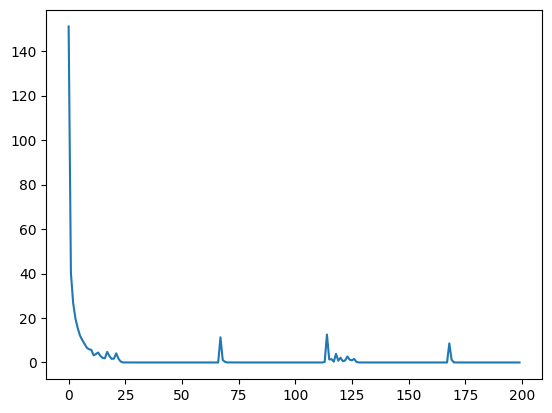

In [6]:


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

epochs = 200
train_ls = []
for epoch in range(epochs):
    loss_sum = 0
    for images, labels in train_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        
        # 训练和测试误差
        outputs = model(images)
        l = loss(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        loss_sum += l.item()
    train_ls.append(loss_sum)
plt.plot(range(epochs), train_ls)
plt.show()
        
        
        

In [7]:
# 测试模型
def Test(test_tensor):
    model.eval()
    with torch.no_grad():
        test_tensor = test_tensor.to("cuda")
        outputs = model(test_tensor)
        _, pred = torch.max(outputs.data, 1)
        print(f"predicted: {pred}")
        return pred.cpu().numpy()
Label = Test(test_tensor)
ImageId = np.arange(1, len(Label)+1)
submission = pd.DataFrame({
    'ImageId': ImageId,
    'Label': Label
})
print(submission)
submission.to_csv('submission.csv', index=False)

predicted: tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')
       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
